## Classic A/B Testing

A/B testing (also known as split testing) is the process of comparing two versions of an asset and measuring the difference in performance.

**Case Overview**:

SmartAd is a mobile first advertiser agency. 

The company provides an additional service called Brand Impact Optimiser (BIO), a lightweight questionnaire, served with every campaign to determine the impact of the ad they design.

The task at hand is to design a reliable hypothesis testing algorithm for the BIO service and determine whether the recent advertising campaign resulted in a significant lift in brand awareness.

**Data**:

The BIO data for this project is a “Yes” and “No” response of online users to the following question:


`Q: Do you know the brand SmartAd?`

      Yes
      No

The data has the following columns:
 **auction_id**,  **experiment**, **date**, **hour**, **device_make**, **platform_os**, **browser**, **yes**, **no**.


## Table of Contents
1. [Libraries](#Libraries)
2. [Dataset](#Dataset)
3. [A/B Testing](#A/B-Testing)

    3.1 [Metrics Definition](#Metrics-Definition)

    3.2 [Experiment Sizing](#Experiment-Sizing)

    3.3 [Collected Data](#Collected-Data)

    3.4 [Effect Size](#Examining-effect-size)


## 1. Libraries

In [2]:
# data preprocessing and linear algebra
import pandas as pd
import numpy as np

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# statistics and math
from scipy import stats
from scipy.stats import skew, norm
import math

# google authentication
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# others
import datetime

# ignore warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Dataset

In [3]:
# function to fetch data
def fetch_data(id, file_name):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(file_name)

  data=pd.read_csv(file_name)
  return data

In [4]:
# fetch the data
data = fetch_data('1YSn01vvlHKQaAIBtwIXRNd-oTaTuDN09', 'ABAdRecall.csv')
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


## 3. A/B Testing

### 3.1 Metrics Definition







#### Invariate Metrics (Sanity Checks).

*   Total Number of users in each group.
*   Average Number of online users per day. (N)
*   Device Make unique counts in each group.
*   Browser type unique counts in each group.
*   PLatform OS unique counts in each group.

#### Evaluation Metrics


*   E/N - (Exposed/ Total Users) (Gross Conversion).
*   Users who Remember the SmartAd ad/E (Retention).
*   Users who Remember the SmartAd ad/N (Net conversion).

**PS**: For the evaluation metrics, the Gross Conversion and the Retention are biased since they don't give room for users in the control group. 
Nevertheless, I'll explore them but put more emphasis on Net Conversion. 


#### 3.1.1  Estimating the baseline values of metrics

**NB**: The data provided doesn't explicitly explain how the users are targeted. I'm making the assumption that all the users(in the exposed and control groups) are tracked by their cookies: their cookies tell they visited the webpages where the ads are. Some of them saw the smartad ad others saw the dummy ad.

In [5]:
# Device makes in each group 
users1 = data.loc[data.experiment == 'exposed']
users2 = data.loc[data.experiment == 'control']
dev_e = users1.device_make.nunique()
dev_c = users2.device_make.nunique()
print('number of unique devices in exposed group:', dev_e)
print('number of unique devices in control group:', dev_c)


# os_platforms in each group 
users1 = data.loc[data.experiment == 'exposed']
users2 = data.loc[data.experiment == 'control']
os_e = users1.platform_os.nunique()
os_c = users2.platform_os.nunique()
print('number of unique os platforms in exposed group:', os_e)
print('number of unique os platforms in control group:', os_c)


# browser types in each group 
users1 = data.loc[data.experiment == 'exposed']
users2 = data.loc[data.experiment == 'control']
b_e = users1.browser.nunique()
b_c = users2.browser.nunique()
print('number of unique browser in exposed group:', b_e)
print('number of unique browser in control group:', b_c)

# total number of users in each  group
users1 = data.loc[data.experiment == 'exposed']
users2 = data.loc[data.experiment == 'control']
u_e = users1.auction_id.nunique()
u_c = users2.auction_id.nunique()
print('total number of users in exposed group:', u_e)
print('total number of users in control group:', u_c)

# lets get the daily rates
# Average total number of users on a daily basis (N)
data.date = pd.to_datetime(data["date"])  #convert date to datetime object
data['day'] = data.date.dt.day    #extract the days
users = data[['auction_id', 'day']]
a = users.groupby('day').count()   #aggregate users per day
N = a.auction_id.mean()
print('Average number of total users per day:', N)  #average users per day


# Average number of users shown the smartad per day(E)
users = data[['auction_id', 'day', 'experiment']]
users = users.loc[users.experiment == 'exposed']
b = users.groupby('day').count()   #aggregate users per day
E = b.auction_id.mean()
print('Average number of users shown the ad per day:', E)  #average per day (we're expecting around half of the total users value)


# gross conversion (exposed/total users)
print('the gross conversion rate is:', E/N)

# Retention (proportion of Users who recall the ad (yes = 1) after being shown)
users = data[['auction_id', 'yes', 'experiment', 'day']]
users = users.loc[users.experiment == 'exposed']
users = users.loc[users.yes == 1]
c = users.groupby('day').count() 
d = c.auction_id.mean()
R = d/E
print('proportion of Average daily users who recall the ad after being shown the ad (Retention):', R)


# Net conversion (proportion of Users who recal the ad to total users generally)
print('the net conversion rate:',d/N )

number of unique devices in exposed group: 218
number of unique devices in control group: 169
number of unique os platforms in exposed group: 3
number of unique os platforms in control group: 2
number of unique browser in exposed group: 12
number of unique browser in control group: 12
total number of users in exposed group: 4006
total number of users in control group: 4071
Average number of total users per day: 1009.625
Average number of users shown the ad per day: 500.75
the gross conversion rate is: 0.495976228797821
proportion of Average daily users who recall the ad after being shown the ad (Retention): 0.07688467299051423
the net conversion rate: 0.03813297016218893


In [6]:
# storing the values in a dictionary
baseline = {"users":1010,"exposed":501,"GConversion":0.49598,
           "Retention":0.07688,"NConversion":0.038133}

#### 3.1.2 Estimating Standard Deviation 
Standard deviation is computed per metric for sample size and confidence interval calculations. Assuming 200 daily users: (should be smaller than the population)

In [7]:
# scaling baseline counts
baseline["users"] = 200
baseline["exposed"]=int(baseline["exposed"]*(200/1010))
baseline

{'GConversion': 0.49598,
 'NConversion': 0.038133,
 'Retention': 0.07688,
 'exposed': 99,
 'users': 200}

Our data is binomially distributed thus: SD=√((p^∗(1−p^))/n)
Assumption: **unit of conversion** = **Unit of analysis**

In [8]:
# calculating the sd
# GCOnversion
GC={}
GC["d_min"]=0.01
GC["p"]=baseline["GConversion"]
GC["n"]=baseline["users"]
GC["sd"]=round(math.sqrt((GC["p"]*(1-GC["p"]))/GC["n"]),5)
GC["sd"]

0.03535

In [9]:
# calculating the sd
# Retention
R={}
R["d_min"]=0.01
R["p"]=baseline["Retention"]
R["n"]=baseline["exposed"]
R["sd"]=round(math.sqrt((R["p"]*(1-R["p"]))/R["n"]),5)
R["sd"]

0.02677

In [10]:
# calculating the sd
# Net COnversion
NC={}
NC["d_min"]=0.01
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["users"]
NC["sd"]=round(math.sqrt((NC["p"]*(1-NC["p"]))/NC["n"]),5)
NC["sd"]

0.01354

### 3.2 Experiment Sizing
Calculating the minimal number of samples we need so that our experiment will have enough statistical power, as well as siginificance.

Using: α=0.05 (significance level ) and β=0. 1(power)


**PS**: d - Minimum detectable effect.

**Hypothesis**:

*H0:Pcontrol = Pexposed*

*H1:Pcontrol − Pexposeed=d*


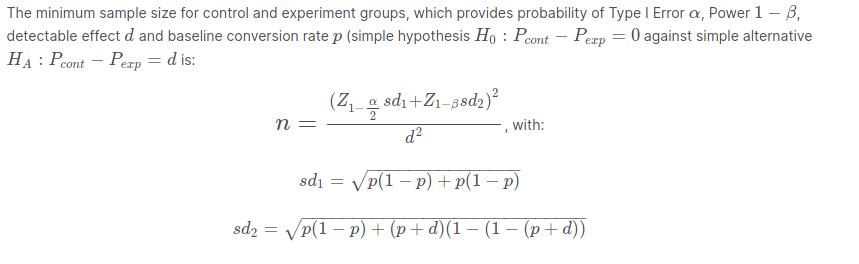

In [11]:
#z_score, critical value and standard deviation

#Inputs: alpha value.
#Returns: z-score for given alpha
def get_z_score(alpha):
    return norm.ppf(alpha)

# Inputs: p-baseline conversion rate which is our estimated p and d-minimum
# Returns: standard deviations list
def get_sds(p,d):
    sd1=math.sqrt(2*p*(1-p))
    sd2=math.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

# Inputs:sd1-sd for the baseline,sd2-sd for the expected change,alpha,beta,d-d_min,p-baseline estimate p
# Returns: the minimum sample size required per group according to metric denominator
def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

In [12]:
#sample size per metric

#GConversion
# dmin
GC["d"]=0.01

GC["SampSize"]=round(get_sampSize(get_sds(GC["p"],GC["d"]),0.05,0.1,GC["d"]))
GC["SampSize"] * 2   #for the 2 groups 

105066.0

Waay higher than our daily users of 1k. If used, result will be biased


In [13]:
# Retention

R["d"]=0.01

R["SampSize"]=round(get_sampSize(get_sds(R["p"],R["d"]),0.05,0.1,R["d"]))
R["SampSize"] * 0.49598 * 2  # convert to total users then get the number for the 2 groups

15136.31764

In [14]:
# Net Conversion
NC["d"]=0.01

NC["SampSize"]=round(get_sampSize(get_sds(NC["p"],NC["d"]),0.05,0.1,NC["d"]))
NC["SampSize"] * 2  #for the 2 groups

16162.0

Up to 16162 users. This is more than what is needed for retention, so this will be our number. Assuming we take 90% of each days users, the data collection period for this experiment should be about 2 weeks + 3 days. 
The data we have is for 8 days, so we're less one week to go.

### 3.3 Collected Data

In [15]:
# print out the first 2 rows
data.head(2)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,day
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0,10
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0,7


In [16]:
# split data into control/exposed groups then agg by day

exposed = data.loc[data.experiment == 'exposed']
control = data.loc[data.experiment == 'control']

df_e = exposed.groupby('day').agg({'auction_id':'count', 'device_make':'count', 'platform_os':'count', 'browser':'count', 'yes':'sum', 'no':'sum'})
df_c = control.groupby('day').agg({'auction_id':'count', 'device_make':'count', 'platform_os':'count', 'browser':'count', 'yes':'sum', 'no':'sum'})

print(df_e)
print(df_c)

     auction_id  device_make  platform_os  browser  yes  no
day                                                        
3           470          470          470      470   43  49
4           477          477          477      477   46  45
5           528          528          528      528   35  39
6           294          294          294      294   23  25
7           257          257          257      257   22  24
8           714          714          714      714   58  61
9           728          728          728      728   55  64
10          538          538          538      538   26  42
     auction_id  device_make  platform_os  browser  yes   no
day                                                         
3          1545         1545         1545     1545  104  129
4           426          426          426      426   30   38
5           362          362          362      362   17   26
6           196          196          196      196   12   14
7           223          223      

#### 3.3.1  Invariant Metrics Check(Sanity)

1.   Total Number of users in each group. 

    Are they balanced? are they different? is the difference statistically significant.



In [17]:
# total number of users in both groups (checking for a significant difference)
print('exposed users', df_e.auction_id.sum())
print('control users', df_c.auction_id.sum())


exposed users 4006
control users 4071


In [18]:
# the difference is slight
# making sure the difference is not significant and is random

a = df_c.auction_id.sum()
b = df_e.auction_id.sum()
c = a + b

p=0.5  #taking equal possibilities
alpha=0.05   #significance level
p_hat=round(a/(c),4)
sd=math.sqrt(p*(1-p)/(c))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")



The confidence interval is between 0.4891 and 0.5109 ; Is 0.504 inside this range?


Our observed p^ is inside this range which means the difference in number of samples between groups is expected.

2. Average Number of users per group per day.

    Are they balance? are they different? is the difference statistically significant.


In [19]:
# Average total number of users on a daily basis (N)
print('Average number of total users per day (both groups):', N)  #average per day
e = df_e.auction_id.mean()
c = df_c.auction_id.mean()
print('Average number of total users per day in the exposed roup:', e)
print('Average number of total users per day in the control group:', c)

Average number of total users per day (both groups): 1009.625
Average number of total users per day in the exposed roup: 500.75
Average number of total users per day in the control group: 508.875


In [20]:
# making sure the difference is not significant and is random

a = e
b = c
d = a + b

p=0.5  #taking equal possibilities
alpha=0.05   #significance level
p_hat=round(a/(d),4)
sd=math.sqrt(p*(1-p)/(d))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4692 and 0.5308 ; Is 0.496 inside this range?


very well!

No difference.


3.   Device Type
  
    Are the unique device counts different in the groups? Is the difference significant?


In [21]:
print(dev_c)
print(dev_e)

169
218


In [22]:
# making sure the difference is not significant and is random

a = dev_c
b = dev_e
c = a + b

p=0.5  #taking equal possibilities
alpha=0.05   #significance level
p_hat=round(a/(c),4)
sd=math.sqrt(p*(1-p)/(c))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")



The confidence interval is between 0.4502 and 0.5498 ; Is 0.4367 inside this range?


Sadly the difference is significant

4.   Platform OS

    Are the unique os_type counts different in the groups? Is the difference significant?



In [23]:
print(os_c)
print(os_e)

2
3


In [24]:
# making sure the difference is not significant and is random

a = os_c
b = os_e
c = a + b

p=0.5  #taking equal possibilities
alpha=0.05   #significance level
p_hat=round(a/(c),4)
sd=math.sqrt(p*(1-p)/(c))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")



The confidence interval is between 0.06169999999999998 and 0.9383 ; Is 0.4 inside this range?


Difference not significant, good to go.

5.   Browser

    Are the unique brpwsers counts different in the groups? Is the difference significant?


In [25]:
print(b_c)
print(b_e)

12
12


In [26]:
# making sure the difference is not significant and is random

a = b_c
b = b_e
c = a + b

p=0.5  #taking equal possibilities
alpha=0.05   #significance level
p_hat=round(a/(c),4)
sd=math.sqrt(p*(1-p)/(c))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")



The confidence interval is between 0.3 and 0.7 ; Is 0.5 inside this range?


Not statistically significant.

### 3.4  Examining effect size
looking at the changes between the control and experiment groups with regard to our evaluation metrics to make sure the difference is there, that it is statistically significant and most importantly practically significant

the evaluation metrics:


*   NetConversion (remember ad/total users)

    Gross conversion is foregone due to the huge sample size required.

    Retention is foregone too due to the bias (mentioned earlier) it has towards the exposed roup.



In [27]:
#Net Conversion - number of users who recall the ad divided by total users
recall_c=df_c["yes"].sum()
recall_e=df_e["yes"].sum()

a = df_c.auction_id.sum()
b = df_e.auction_id.sum()
c = a + b

NC_cont=recall_c/a
NC_exp=recall_e/b
NC_pooled=(recall_c+recall_e)/(a+b)
NC_sd_pooled=math.sqrt(NC_pooled*(1-NC_pooled)*(1/a+1/b))
NC_ME=round(get_z_score(1-alpha/2)*NC_sd_pooled,4)
NC_diff=round(NC_exp-NC_cont,4)
print("The change due to the experiment is",NC_diff*100,"%")
print("Confidence Interval: [",NC_diff-NC_ME,",",NC_diff+NC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",-NC["d_min"],"is not in the CI as well.")

The change due to the experiment is 1.2 %
Confidence Interval: [ 0.0008000000000000004 , 0.0232 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if -0.01 is not in the CI as well.


very well! 

According to this result there was a change due to the experiment, (we reject the null hypothesis) that change was both statistically and practically significant. We have a positive change of 1.2% (we were willing to accept any change greater than 1% (d min)). This means the Net COnversion(Users who recall the Ad/ total users) of the exposed group (the one exposed to the SmartAd Ad) has increased by 1% and this change is significant.

In [28]:
# generate the requirements file
!pip freeze > requirements.txt